## How does my tidal tensor change in time? 
Qui voglio moltissimo un filmato 

In [20]:
import tstrippy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
def dimesionless_miyamoto_nagai_tidal_tensor(params, xp,yp,zp):
    bp = params 
    beta = 1.0 + np.sqrt ( zp**2 + bp**2 )
    betaPrime = zp/np.sqrt(zp**3 + bp**2)
    betaPrimePrime = bp**2 / np.power(zp**2 + bp**2,3/2)
    D = np.sqrt ( xp**2 + yp**2 + beta**2 )
    T = np.zeros((3,3))
    # diagonals
    T[0,0] = 1 - 3*xp**2/D**2
    T[1,1] = 1 - 3*yp**2/D**2
    T[2,2] = betaPrime**2 + beta*betaPrimePrime - 3*(beta*betaPrime)**2 / D**2
    T[0,1] = -3*xp*yp/D**2
    T[0,2] = -3*xp*beta*betaPrime/D**2
    T[1,0] = -3*xp*yp/D**2
    T[1,2] = -3*yp*beta*betaPrime/D**2
    T[1,0] = T[0,1]
    T[2,0] = T[0,2]
    T[2,1] = T[1,2]
    T = -T/D**3
    return T

In [4]:
def miyamoto_nagai_tidal_tensor(params,x,y,z):
    """
    Miyamoto-Nagai potential
    """
    G,M,a,b = params
    # make all dimensionless for for convenience
    xp = x/a
    yp = y/a
    zp = z/a
    bp = b/a
    T = dimesionless_miyamoto_nagai_tidal_tensor(bp, xp, yp, zp)
    # scale up the tensor 
    factor = G*M/a**3
    return T*factor


In [73]:
def generate_unit_sphere(npoints=30):
    # 1. Generate points on a sphere
    theta = np.linspace(0, np.pi, npoints)
    phi = np.linspace(0, 2*np.pi, npoints)
    theta, phi = np.meshgrid(theta, phi)
    r = 1
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    
    return x,y,z

In [61]:
x,y,z = 3,1,3
pos = np.array([x,y,z])
bp = 1

In [62]:
tidal_tensor = dimesionless_miyamoto_nagai_tidal_tensor(bp, x, y, z)

In [63]:
dx = 1/100
nvec = 10
dXs = np.linspace(-dx,dx,nvec)
dYs = np.linspace(-dx,dx,nvec)
dXs,dYs = np.meshgrid(dXs,dYs)
dXs,dYs = dXs.flatten(), dYs.flatten()
dZs = np.zeros_like(dXs)
field = np.array([dXs,dYs,dZs])
# compute the forces at each point 
forces = tidal_tensor @ field
f_mag = np.linalg.norm(forces, axis=0)
cmap = mpl.colormaps['rainbow']
norm = mpl.colors.Normalize(vmin=f_mag.min(), vmax=f_mag.max())

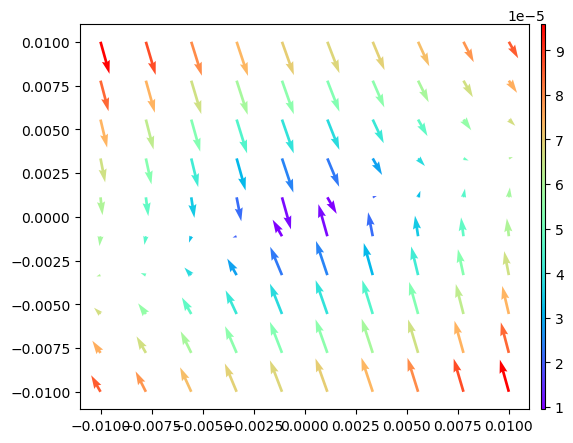

In [64]:
fig = plt.figure(figsize=(6,5 ))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1/100], wspace=0.05)
axis = fig.add_subplot(gs[0, 0])
caxis = fig.add_subplot(gs[0, 1])
# plot the forces
axis.quiver(dXs, dYs, forces[0]/f_mag, forces[1]/f_mag, color=cmap(norm(f_mag)), alpha=1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=caxis)

In [74]:
x,y,z = generate_unit_sphere(30)
points = np.array([x.flatten(), y.flatten(), z.flatten()])
# apply the deformation 
deformed_points = tidal_tensor @ points
# reshape the points
x = deformed_points[0].reshape(x.shape)
y = deformed_points[1].reshape(y.shape)
z = deformed_points[2].reshape(z.shape)

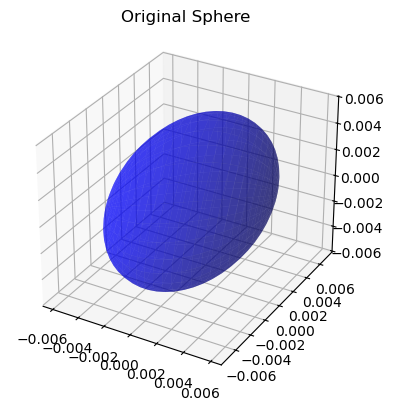

In [78]:
import numpy as np
import matplotlib.pyplot as plt



# 3. Plot
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(x, y, z, color='b', alpha=0.5)
ax.set_title('Original Sphere')
ax.set_aspect("equal")


plt.show()

(30, 30)